In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../codes/")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../codes/scpy2/")))

from scpy2.utils.nbmagics import install_magics
install_magics()
del install_magics

D:\Program_File\VSCode_Portable\workon_env\pyElan\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
d:\09_Work\Jun_Workspace\Python_Scientific_Computing_Best_Practices\繁中程式碼\codes\scpy2\utils\program_finder.py:25: UserWarning: Inkscape not found
  warnings.warn("Inkscape not found")


In [2]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams["font.family"] = "simsun" # 可以直接修改設定字典，設定預設字型，這樣就不需要在每次繪製文字時設定字型了
plt.rcParams['axes.unicode_minus']=False    # 當座標軸上的 負號無法正常顯示時，需加這行 code

In [3]:
%matplotlib_svg
import numpy as np

### 廣義ufunc函數

從 numpy 1.8 開始正式支援廣義 ufunc 函數(generalized ufunc，以下簡稱 gufunc)。gufunc 是對 ufunc 的推廣，  
所謂 ufunc 就是將對單一數值的運算透過廣播運用到整個陣列中的所有元素之上，  
而 gufunc 則是將對單一矩陣的運算透過廣播運用到整個陣列之上。  
例如 `np.linalg.inv()` 是求反矩陣的 gufunc 函數。在其文件中描述其輸入輸出陣列的形狀如下：
```
ainv = inv(a)
a: (..., M,M)
ainv: (..., M,M)
```
輸入陣列 a 的形狀中帶有 "..." ，它表示 0 到任意個軸。當它為空時，就是對單一矩陣求逆， gufunc 函數將對這些軸進行廣播運算。最後兩個軸的長度為 M，表示任意大小的方形矩陣。

> **TIP**

> NumPy中的線性代數模組`linalg`中提供的函數大都為廣義ufunc函數。在SciPy中也提供了線性代數模組`linalg`，但其中的函數都是一般函數，只能對單一矩陣進行計算。關於線性代數函數庫的用法將在下一章進行詳細介紹。

在輸出陣列 ainv 中，由於反矩陣的形狀與原矩陣相同，因此 ainv 的最後兩軸的形狀也是 (M,M)。"..."表示廣播運算之後的形狀，而由於矩陣求逆只對一個矩陣進行運算，因此 "..." 的形狀和 a 中的 "..." 的形狀相同。

在下面的實例中，a 的形狀為 (10, 20, 3, 3) ，其中 (10, 20) 與 "..." 對應，3 與 M 對應。而 `inv()` 透過廣播運算對 10x20 個形狀為 (3,3) 矩陣求逆。獲得的結果 ainv 的形狀與 a 相同，也是 (10, 20,3,3)。

In [4]:
a = np.random.rand(10, 20, 3, 3)
ainv = np.linalg.inv(a)
ainv.shape

(10, 20, 3, 3)

下面的程式驗證第 i 行、第 j 列的矩陣及其反矩陣的乘積，應該近似等於 3 階單位矩陣：

In [5]:
i, j = 3, 4
np.allclose(np.dot(a[i, j], ainv[i, j]), np.eye(3))

True

`np.linalg.det()` 計算矩陣的行列式，它也是一個 gufunc 函數。它的輸入輸出的形狀為：
```
adet = det(a)
a: (..., M,M)
adet: (...)
```

In [6]:
adet = np.linalg.det(a)
adet.shape

(10, 20)

下面以多個二次函數的資料擬合為例，介紹如何使用 gufunc 函數加強運算效率。  
首先透過亂數函數建立測試用的資料 x 和 y ，這兩個陣列的形狀都為(n,10)。其中的每行資料 (`x[i]` 和 `y[i]`)組成一個曲線擬合的資料集，它們的關係為：  
$y=\beta_2+\beta_1x+\beta_0x^2$  
現在需要計算每對資料所對應的係數 $\beta$。

In [7]:
n = 10000
np.random.seed(0)
beta = np.random.rand(n, 3)
x = np.random.rand(n, 10)
y = beta[:,2, None] + x*beta[:, 1, None] + x**2*beta[:, 0, None]

顯然使用前面介紹過的 `np.polyfint()` 可以很方便地完成這個工作，下面的程式輸出第 42 組的實際係數以及擬合的結果：

In [8]:
print( beta[42] )
print( np.polyfit(x[42], y[42], 2) )

[0.0191932  0.30157482 0.66017354]
[0.0191932  0.30157482 0.66017354]


只需要循環呼叫 n 次 `np.polyfit()` 即可獲得所需的結果，但是它的運算速度有些慢：

In [9]:
%time beta2 = np.vstack([np.polyfit(x[i], y[i], 2) for i in range(n)])

Wall time: 558 ms


In [10]:
np.allclose(beta, beta2)

True

在 `np.polyfit()` 內部實際上是透過呼叫最小平方法函數 `np.linalg.lstsq()` 來實現多項式擬合的，也可以直接呼叫 `lstsq()` 計算係數：

In [12]:
xx = np.column_stack(([x[42]**2, x[42], np.ones_like(x[42])]))
print( np.linalg.lstsq(xx, y[42])[0] )

[0.0191932  0.30157482 0.66017354]


<ipython-input-12-bbc35c9e38f8>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  print( np.linalg.lstsq(xx, y[42])[0] )


但遺憾的是，目前 `np.linalg.lstsq()` 還不是 gufunc 函數，因此無法直接使用它計算所有資料組的擬合係數。然而 `np.linalg` 中對線性方程組求解的函數 `solve()` 是一個 gufunc 函數。並且根據最小平方法的公式：

$\beta=solve(X^TX)^{-1}X^Ty$

只需要求出 $X^TX$ 和 $X^Ty$ ，就可以使用 `np.linalg.solve()` 計算出 $\hat\beta=solve(X^TX, X^Ty)$ 。為了實現這個運算，還需要計算矩陣乘積的 gufunc 函數。然而 `dot()` 並不是一個 gufunc 函數，因為它不遵循廣播規。 numpy 中目前還沒有正式提供計算矩陣乘積的 gufunc 函數，不過 `umath_tests` 模組中提供了一個測試用的函數：`matrix_multiply()` 。下面的程式使用它和 `solve()` 實現高速多項式擬合運算，它所需的時間約為 `polyfit()` 版本的 1/50。

In [14]:
%%time
X = np.dstack([x**2, x, np.ones_like(x)])
Xt = X.swapaxes(-1, -2)

import numpy.core.umath_tests as umath
A = umath.matrix_multiply(Xt, X)
b = umath.matrix_multiply(Xt, y[..., None]).squeeze()

beta3 = np.linalg.solve(A, b)

print( np.allclose(beta3, beta2) )

True
Wall time: 52.9 ms


<timed exec>:4: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


在上面的運算中，$X$ 的形狀為 (10000, 10, 3) ，$X_t$ 的形狀為 (10000, 3, 10)。 `matrix_multiply()` 的各個參數和傳回值的形狀如下：
```
c = matrix_multiply(a, b)
a: (..., M, N)
b: (..., N, K)
c: (..., M, K)
```
呼叫 `matrix_multiply()` 對 $X_t$ 和 $X$ 中的每對矩陣進行乘積運算，獲得的結果 A 的形狀為 (10000, 3, 3)。而為了計算 $X^Ty$，需要透過 `y[..., None]` 將 y 變成形狀為 (10000, 10, 1) 的陣列。`matrix_multiply(Xt, y[..., None])`所得到的形狀為 (10000, 3, 1)。呼叫其 `squeeze()` ，刪除長度為 1 的軸。這樣 b 的形狀為 (10000, 3)。

`solve()` 的參數 b 支援兩種形狀，其中第一種情況的形狀如下：
```
x = solve(a, b)
a: (..., M, M)
b: (..., M)
x: (..., M)
```
因此 `solve()` 的傳回值 beta3 的形狀為 (10000, 3)。

前面的實例中，使用的都是最簡單的廣播規則。實際上 gufunc 函數支援所有的 ufunc 函數的廣播規則。因此形狀分別為 (a,m,n) 和 (b,l,n,k) 的兩個陣列透過 `matrix_multiply()` 乘積之後獲得的陣列的形狀為 (b,a,m,k)。下面看一個使用 gufunc 函數廣播運算的實例：

在二維平面上的旋轉矩陣為:

$M(\theta)=\begin{bmatrix}cos\theta & -sin\theta \\sin\theta & cos\theta \end{bmatrix}$

它能將平面上的某個點的座標圍繞原點旋轉 $\theta$。對於形狀為 (N, 2) 的矩陣 P，可以表示平面上 N 個點的座標。而矩陣乘積獲得的則是這 N 個點繞座標原點旋轉 $\theta$ 之後的座標。下面的程式使用 `matrix_multiply()` 將 3 條曲線上的座標點分別旋轉 4 個角度，獲得 12 條曲線。

呼叫 `matrix_multiply()` 時兩個參數陣列的形狀分別為 (3, 100, 2) 和 (4, 1, 2, 2) ，其中廣播軸的形狀分別為 (3, ) 和 (4, 1)，運算軸的形狀分別為(100, 2)和(2, 2)。廣播軸進行廣播之後的形狀為(4,3)，而運算軸進行矩陣乘積之後的形狀為 (100, 2)，因此結果 rpoints 的形狀為(4, 3, 100, 2)。

In [17]:
M = np.array([[[np.cos(t), -np.sin(t)], 
               [np.sin(t), np.cos(t)]]
             for t in np.linspace(0, np.pi, 4, endpoint=False)])

x = np.linspace(-1, 1, 100)
points = np.array((np.c_[x, x], np.c_[x, x**3], np.c_[x**3, x]))
rpoints = umath.matrix_multiply(points, M[:, None, ...])

print( points.shape, M.shape, rpoints.shape )

(3, 100, 2) (4, 2, 2) (4, 3, 100, 2)


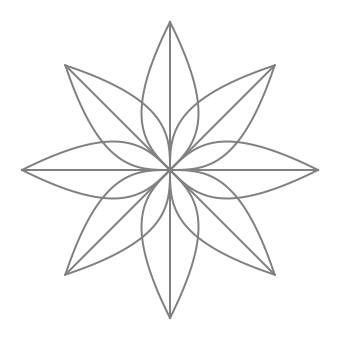

In [16]:
#%figonly=使用矩陣乘積的廣播運算將3條曲線分別旋轉4個角度
import pylab as pl

pl.figure(figsize=(6, 6))
for t in rpoints.reshape(-1, 100, 2):
    pl.plot(t[:,0], t[:,1], color="gray", lw=2)
ax = pl.gca()
ax.set_aspect("equal")
ax.axis("off");